<a href="https://colab.research.google.com/github/rukka0808/Deep-Learning-Study/blob/main/YOLO_Lane_Mask_Filter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/AlexeyAB/darknet

Cloning into 'darknet'...
remote: Enumerating objects: 15298, done.
remote: Total 15298 (delta 0), reused 0 (delta 0), pack-reused 15298
Receiving objects: 100% (15298/15298), 13.65 MiB | 14.59 MiB/s, done.
Resolving deltas: 100% (10397/10397), done.


In [2]:
%cd darknet

/content/darknet


In [3]:
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile

In [4]:
!make

mkdir -p ./obj/
mkdir -p backup
chmod +x *.sh
g++ -std=c++11 -std=c++11 -Iinclude/ -I3rdparty/stb/include -DOPENCV `pkg-config --cflags opencv4 2> /dev/null || pkg-config --cflags opencv` -DGPU -I/usr/local/cuda/include/ -DCUDNN -Wall -Wfatal-errors -Wno-unused-result -Wno-unknown-pragmas -fPIC -Ofast -DOPENCV -DGPU -DCUDNN -I/usr/local/cudnn/include -c ./src/image_opencv.cpp -o obj/image_opencv.o
./src/image_opencv.cpp: In function ‘void draw_detections_cv_v3(void**, detection*, int, float, char**, image**, int, int)’:
./src/image_opencv.cpp:946:23: warning: variable ‘rgb’ set but not used [-Wunused-but-set-variable]
                 float rgb[3];
                       ^~~
./src/image_opencv.cpp: In function ‘void draw_train_loss(char*, void**, int, float, float, int, int, float, int, char*, float, int, int, double)’:
./src/image_opencv.cpp:1147:13: warning: this ‘if’ clause does not guard... [-Wmisleading-indentation]
             if (iteration_old == 0)
             ^~
./src/image_

In [5]:
!wget https://pjreddie.com/media/files/yolov3.weights

--2021-08-16 07:26:15--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘yolov3.weights’

yolov3.weights      100%[===================>] 236.52M  15.3MB/s    in 14s     

2021-08-16 07:26:30 (16.6 MB/s) - ‘yolov3.weights’ saved [248007048/248007048]



In [6]:
import cv2
import IPython
import numpy as np
import time
import math
from google.colab.patches import cv2_imshow

In [7]:
min_confidence = 0.5
weight_file = 'yolov3.weights'
cfg_file = 'cfg/yolov3.cfg'
name_file = 'data/coco.names'

file_name = 'cabc30fc-e7726578.mp4'

In [8]:
net = cv2.dnn.readNet(weight_file, cfg_file)

In [9]:
classes = []
with open(name_file, 'r') as f:
    classes = [line.strip() for line in f.readlines()]
print(classes)

['person', 'bicycle', 'car', 'motorbike', 'aeroplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'sofa', 'pottedplant', 'bed', 'diningtable', 'toilet', 'tvmonitor', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']


In [10]:
layer_names = net.getLayerNames()
output_layers = [layer_names[i[0] - 1] for i in net.getUnconnectedOutLayers()]

In [11]:
from google.colab import files
files.upload()

Saving cabc30fc-e7726578.mp4 to cabc30fc-e7726578.mp4


In [12]:
frame_count = 0
writer = None
output_name = 'output_video_car.avi'

In [13]:
def writeFrame(img):
  global writer
  h, w, = img.shape[:2]
  if writer is None and output_name is not None:
    fourcc = cv2.VideoWriter_fourcc(*'MJPG')
    writer = cv2.VideoWriter(output_name, fourcc, 24, (w, h), True)
  if writer is not None:
    writer.write(img)

In [14]:
def detectAndDisplay(frame):
    global frame_count 
    frame_count += 1
    start_time = time.time()
    #frame 초기화
    IPython.display.clear_output(wait=True)
    height, width, channedls = frame.shape
    
    # Detecting objects
    blob = cv2.dnn.blobFromImage(frame, 0.00392, (416, 416), (0, 0, 0), True, crop=False)

    net.setInput(blob)
    outs = net.forward(output_layers)

    class_ids = []
    confidences = []
    boxes = []

    for out in outs:
        for detection in out:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            # Filter only car == 2
            if (confidence > min_confidence) and (class_id == 2):
                # Object detected
                center_x = int(detection[0] * width)
                center_y = int(detection[1] * height)
                w = int(detection[2] * width)
                h = int(detection[3] * height)

                # Rectangle coordinates
                x = int(center_x - w / 2)
                y = int(center_y - h / 2)

                boxes.append([x, y, w, h])
                confidences.append(float(confidence))
                class_ids.append(class_id)

    # Region of Interest
    mask = np.zeros((height,width), dtype='uint8')
    poly_top = int(0.65 * height)
    poly_bottom = int(0.85 * height)
    poly_left = int(0.47 * width)
    poly_right = int(0.53 * width)
    roi_left = int(0.3 * width)
    roi_right = int(0.6 * width)
    poly_margin = 50
    polygons = np.array([[(0+poly_margin,poly_bottom), (poly_left, poly_top), (poly_right, poly_top), (width-poly_margin, poly_bottom)]])
    cv2.fillPoly(mask, polygons, 255)

    indexes = cv2.dnn.NMSBoxes(boxes, confidences, min_confidence, 0.4)
    font = cv2.FONT_HERSHEY_COMPLEX
    margin = 5
    for i in range(len(boxes)):
        if i in indexes:
            x, y, w, h = boxes[i]
            # Bitwise operation between box and mask 
            box = np.array([[(x-margin, y+h+margin), (x-margin, y-margin), (x+w+margin, y), (x+w+margin, y+h+margin)]])
            cv2.fillPoly(mask, box, 0) 
            # Eliminate Small object(<50)
            if (w > 50) and (x > roi_left) and (x < roi_right):
                label = str(classes[class_ids[i]])
                print(class_ids[i], label, w)
                cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)
                cv2.putText(frame, label, (x, y + 30), font, 0.5, (0, 255, 0), 1) 

    #cv2_imshow(mask)
    # Lane Detection
    gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
    # GaussianBlur for refucing noise
    blur = cv2.GaussianBlur(gray, (5, 5), 0)
    canny = cv2.Canny(blur, 40, 130)

    # Bitwise operation between poly and mask
    masked = cv2.bitwise_and(canny, mask)
    #cv2_imshow(masked)
    # Lane Detection
    lines = cv2.HoughLinesP(masked, 2, np.pi / 180, 20, np.array([]), 20, 10)
    if lines is not None:
        for line in lines:
            for x1, y1, x2, y2 in line:
                cv2.line(frame, (x1,y1), (x2,y2), (0,  255, 255), 5)

    frame_time = time.time() - start_time 
    print("Frame {} time {}".format(frame_count, frame_time))
    cv2_imshow(frame)   
    writeFrame(frame)

2 car 85
2 car 54
Frame 111 time 2.2268712520599365


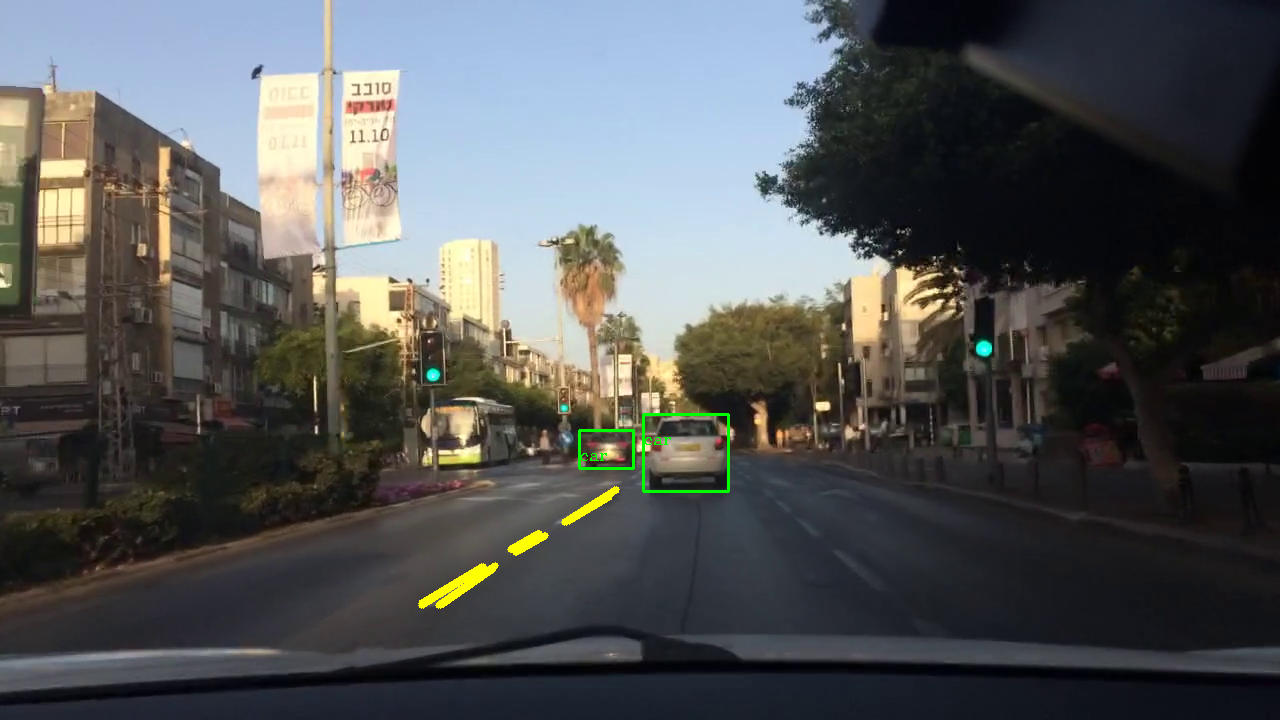

In [ ]:
#-- 2. Read the video stream
cap = cv2.VideoCapture(file_name)
if not cap.isOpened:
    print('--(!)Error opening video capture')
    exit(0)
while True:
    ret, frame = cap.read()
    if frame is None:
        print('--(!) No captured frame -- Break!')
        break
    detectAndDisplay(frame)